In [1]:
%cd ../..

C:\Users\ManuJoseph\OneDrive - Thoucentric\Work\Projects\Playground\AdvancedTimeSeriesForecastingBook\Github\Modern-Time-Series-Forecasting-with-Python-


In [2]:
import os
import random
import time

random.seed(42)
import joblib
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = "plotly_white"

import copy
import warnings
from pathlib import Path

import humanize
from darts.metrics import mae, mase, mse
from sklearn.preprocessing import StandardScaler
from src.forecasting.ml_forecasting import (
    FeatureConfig,
    MissingValueConfig,
    MLForecast,
    ModelConfig,
    calculate_metrics,
)
from src.utils import plotting_utils
from src.utils.general import LogTime
from src.utils.ts_utils import darts_metrics_adapter, forecast_bias
from tqdm.autonotebook import tqdm

%load_ext autoreload
%autoreload 2
np.random.seed(42)
tqdm.pandas()

C:\Users\ManuJoseph\OneDrive - Thoucentric\Work\Projects\Playground\AdvancedTimeSeriesForecastingBook\Github\Modern-Time-Series-Forecasting-with-Python-\src\utils\data_utils.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
os.makedirs("imgs/chapter_8", exist_ok=True)
preprocessed = Path("data/london_smart_meters/preprocessed")
output = Path("data/london_smart_meters/output")

In [4]:
from itertools import cycle
def format_plot(fig, legends=None, xlabel="Time", ylabel="Value", title="", font_size=15):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t: t.update(name=next(names)))
    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        title_text=title,
        title={"x": 0.5, "xanchor": "center", "yanchor": "top"},
        titlefont={"size": 20},
        legend_title=None,
        legend=dict(
            font=dict(size=font_size),
            orientation="h",
            yanchor="bottom",
            y=0.9,
            xanchor="right",
            x=1,
        ),
        yaxis=dict(
            title_text=ylabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        ),
        xaxis=dict(
            title_text=xlabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        )
    )
    return fig

In [5]:
#Readin the missing value imputed and train test split data
train_df = pd.read_parquet(preprocessed/"selected_blocks_train_missing_imputed_feature_engg.parquet")
# Read in the Validation dataset as test_df so that we predict on it
test_df = pd.read_parquet(preprocessed/"selected_blocks_val_missing_imputed_feature_engg.parquet")
# test_df = pd.read_parquet(preprocessed/"block_0-7_test_missing_imputed_feature_engg.parquet")

### Loading the single step backtesting baselines for validation

In [6]:
baseline_aggregate_metrics_df = pd.read_pickle(output/"ml_single_step_aggregate_metrics_auto_stationary_val.pkl")

In [7]:
len(train_df.LCLid.unique())

150

# Feature Definition

In [8]:
feat_config = FeatureConfig(
    date="timestamp",
    target="energy_consumption",
    continuous_features=[
        "visibility",
        "windBearing",
        "temperature",
        "dewPoint",
        "pressure",
        "apparentTemperature",
        "windSpeed",
        "humidity",
        "energy_consumption_lag_1",
        "energy_consumption_lag_2",
        "energy_consumption_lag_3",
        "energy_consumption_lag_4",
        "energy_consumption_lag_5",
        "energy_consumption_lag_46",
        "energy_consumption_lag_47",
        "energy_consumption_lag_48",
        "energy_consumption_lag_49",
        "energy_consumption_lag_50",
        "energy_consumption_lag_334",
        "energy_consumption_lag_335",
        "energy_consumption_lag_336",
        "energy_consumption_lag_337",
        "energy_consumption_lag_338",
        "energy_consumption_rolling_3_mean",
        "energy_consumption_rolling_3_std",
        "energy_consumption_rolling_6_mean",
        "energy_consumption_rolling_6_std",
        "energy_consumption_rolling_12_mean",
        "energy_consumption_rolling_12_std",
        "energy_consumption_rolling_48_mean",
        "energy_consumption_rolling_48_std",
        "energy_consumption_48_seasonal_rolling_3_mean",
        "energy_consumption_48_seasonal_rolling_3_std",
        "energy_consumption_336_seasonal_rolling_3_mean",
        "energy_consumption_336_seasonal_rolling_3_std",
        "energy_consumption_ewma_span_2880",
        "energy_consumption_ewma_span_336",
        "energy_consumption_ewma_span_48",
        "timestamp_Elapsed",
        "timestamp_Month_sin_1",
        "timestamp_Month_sin_2",
        "timestamp_Month_sin_3",
        "timestamp_Month_sin_4",
        "timestamp_Month_sin_5",
        "timestamp_Month_cos_1",
        "timestamp_Month_cos_2",
        "timestamp_Month_cos_3",
        "timestamp_Month_cos_4",
        "timestamp_Month_cos_5",
        "timestamp_Hour_sin_1",
        "timestamp_Hour_sin_2",
        "timestamp_Hour_sin_3",
        "timestamp_Hour_sin_4",
        "timestamp_Hour_sin_5",
        "timestamp_Hour_cos_1",
        "timestamp_Hour_cos_2",
        "timestamp_Hour_cos_3",
        "timestamp_Hour_cos_4",
        "timestamp_Hour_cos_5",
        "timestamp_Minute_sin_1",
        "timestamp_Minute_sin_2",
        "timestamp_Minute_sin_3",
        "timestamp_Minute_sin_4",
        "timestamp_Minute_sin_5",
        "timestamp_Minute_cos_1",
        "timestamp_Minute_cos_2",
        "timestamp_Minute_cos_3",
        "timestamp_Minute_cos_4",
        "timestamp_Minute_cos_5",
    ],
    categorical_features=[
        "holidays",
        "precipType",
        "icon",
        "summary",
        "timestamp_Month",
        "timestamp_Quarter",
        "timestamp_WeekDay",
        "timestamp_Dayofweek",
        "timestamp_Dayofyear",
        "timestamp_Hour",
        "timestamp_Minute"
    ],
    boolean_features=[
        "timestamp_Is_quarter_end",
        "timestamp_Is_quarter_start",
        "timestamp_Is_year_end",
        "timestamp_Is_year_start",
        "timestamp_Is_month_start",
    ],
    index_cols=["LCLid","timestamp"],
    exogenous_features=[
        "holidays",
        "precipType",
        "icon",
        "summary",
        "visibility",
        "windBearing",
        "temperature",
        "dewPoint",
        "pressure",
        "apparentTemperature",
        "windSpeed",
        "humidity",
    ],
)


# Missing Value Handling

In [9]:
missing_value_config = MissingValueConfig(
    bfill_columns=[
        "energy_consumption_lag_1",
        "energy_consumption_lag_2",
        "energy_consumption_lag_3",
        "energy_consumption_lag_4",
        "energy_consumption_lag_5",
        "energy_consumption_lag_46",
        "energy_consumption_lag_47",
        "energy_consumption_lag_48",
        "energy_consumption_lag_49",
        "energy_consumption_lag_50",
        "energy_consumption_lag_334",
        "energy_consumption_lag_335",
        "energy_consumption_lag_336",
        "energy_consumption_lag_337",
        "energy_consumption_lag_338",
        "energy_consumption_rolling_3_mean",
        "energy_consumption_rolling_3_std",
        "energy_consumption_rolling_6_mean",
        "energy_consumption_rolling_6_std",
        "energy_consumption_rolling_12_mean",
        "energy_consumption_rolling_12_std",
        "energy_consumption_rolling_48_mean",
        "energy_consumption_rolling_48_std",
        "energy_consumption_48_seasonal_rolling_3_mean",
        "energy_consumption_48_seasonal_rolling_3_std",
        "energy_consumption_336_seasonal_rolling_3_mean",
        "energy_consumption_336_seasonal_rolling_3_std",
        "energy_consumption_ewma__span_2880",
        "energy_consumption_ewma__span_336",
        "energy_consumption_ewma__span_48",
    ],
    ffill_columns=[],
    zero_fill_columns=[],
)

# Training Global ML Model

In [10]:
from src.forecasting.ml_forecasting import calculate_metrics
from src.utils import ts_utils

In [11]:
def train_model(
    model_config,
    feature_config,
    missing_config,
    train_features,
    train_target,
    test_features,
    fit_kwargs={}
):
    ml_model = MLForecast(
        model_config=model_config,
        feature_config=feature_config,
        missing_config=missing_config,
    )
    ml_model.fit(train_features, train_target, fit_kwargs=fit_kwargs)
    y_pred = ml_model.predict(test_features)
    feat_df = ml_model.feature_importance()
    return y_pred, feat_df

def evaluate_forecast(y_pred, test_target, train_target, model_config):
    metric_l = []
    for _id in tqdm(test_target.index.get_level_values(0).remove_unused_categories().categories, desc="Calculating metrics..."):
        target = test_target.xs(_id)
        _y_pred = y_pred.xs(_id)
        history = train_target.xs(_id)
        metric_l.append(
            calculate_metrics(target, _y_pred, name=model_config.name, y_train=history)
        )
    eval_metrics_df = pd.DataFrame(metric_l)
    agg_metrics = {
            "Algorithm": model_config.name,
            "MAE": ts_utils.mae(
                test_target['energy_consumption'], y_pred
            ),
            "MSE": ts_utils.mse(
                test_target['energy_consumption'], y_pred
            ),
            "meanMASE": eval_metrics_df.loc[:, "MASE"].mean(),
            "Forecast Bias": ts_utils.forecast_bias_aggregate(
                test_target['energy_consumption'], y_pred
            )
    }
    return agg_metrics, eval_metrics_df

In [12]:
metric_record = []
individual_metrics = dict()

metric_record = (
    baseline_aggregate_metrics_df.iloc[[4]]
    .to_dict(orient="records")
)

## Baseline

In [13]:
_feat_config = copy.deepcopy(feat_config)

train_features, train_target, train_original_target = _feat_config.get_X_y(
    train_df, categorical=False, exogenous=False
)

test_features, test_target, test_original_target = _feat_config.get_X_y(
    test_df, categorical=False, exogenous=False
)

pred_df = test_target.copy()

In [14]:
from lightgbm import LGBMRegressor
model_config = ModelConfig(
    model=LGBMRegressor(random_state=42),
    name="GFM Baseline",
    # LGBM is not sensitive to normalized data
    normalize=False,
    # LGBM can handle missing values
    fill_missing=False,
)

In [15]:
with LogTime() as timer:
    y_pred, feat_df = train_model(
        model_config,
        _feat_config,
        missing_value_config,
        train_features,
        train_target,
        test_features,
    )
agg_metrics, eval_metrics_df = evaluate_forecast(
    y_pred, test_target, train_target, model_config
)
agg_metrics["Time Elapsed"] = timer.elapsed
metric_record.append(agg_metrics)
individual_metrics[model_config.name]=eval_metrics_df
pred_df = pred_df.join(y_pred)

Time Elapsed: 28 seconds


Calculating metrics...:   0%|          | 0/150 [00:00<?, ?it/s]

In [16]:
pd.DataFrame(metric_record)

Algorithm       MAE       MSE  meanMASE  Forecast Bias  Time Elapsed
0      LightGBM  0.077183  0.027510  0.978056       0.050231           NaN
1  GFM Baseline  0.079581  0.027326  1.013393       0.218127     28.718087

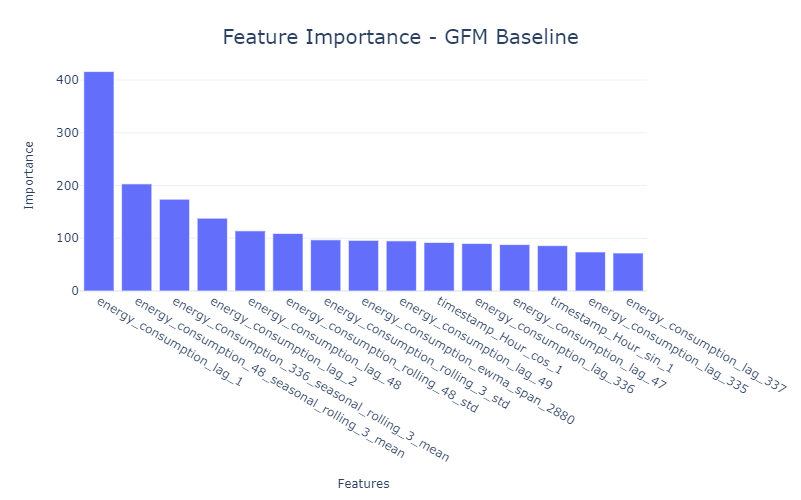

In [17]:
fig = px.bar(feat_df.head(15), x="feature", y="importance")
format_plot(fig, xlabel="Features", ylabel="Importance", title=f"Feature Importance - {model_config.name}", font_size=12)
fig.write_image("imgs/chapter_8/baseline_fimp.png")
fig.show()

## With Metadata

In [18]:
feat_conf_dict = copy.deepcopy(feat_config.__dict__)
feat_conf_dict.pop("feature_list")
feat_conf_dict['categorical_features']+=["stdorToU", "Acorn", "Acorn_grouped", "LCLid"]
_feat_config = FeatureConfig(**feat_conf_dict)

train_features, train_target, train_original_target = _feat_config.get_X_y(
    train_df, categorical=True, exogenous=False
)
# Loading the Validation as test
test_features, test_target, test_original_target = _feat_config.get_X_y(
    test_df, categorical=True, exogenous=False
)

cat_features = set(train_features.columns).intersection(_feat_config.categorical_features)

### CountEncoder

In [19]:
from category_encoders import CountEncoder
from lightgbm import LGBMRegressor

cat_encoder = CountEncoder(cols=cat_features)

model_config = ModelConfig(
    model=LGBMRegressor(random_state=42),
    name="GFM+Meta (CountEncoder)",
    # LGBM is not sensitive to normalized data
    normalize=False,
    # LGBM can handle missing values
    fill_missing=False,
    encode_categorical=True,
    categorical_encoder=cat_encoder
)

In [20]:
with LogTime() as timer:
    y_pred, feat_df = train_model(
        model_config,
        _feat_config,
        missing_value_config,
        train_features,
        train_target,
        test_features,
    )
agg_metrics, eval_metrics_df = evaluate_forecast(y_pred, test_target, train_target, model_config)
agg_metrics["Time Elapsed"] = timer.elapsed
metric_record.append(agg_metrics)
individual_metrics[model_config.name]=eval_metrics_df
pred_df = pred_df.join(y_pred)

Time Elapsed: 1 minute and 8 seconds


Calculating metrics...:   0%|          | 0/150 [00:00<?, ?it/s]

In [21]:
pd.DataFrame(metric_record)

Algorithm       MAE       MSE  meanMASE  Forecast Bias  \
0                 LightGBM  0.077183  0.027510  0.978056       0.050231   
1             GFM Baseline  0.079581  0.027326  1.013393       0.218127   
2  GFM+Meta (CountEncoder)  0.079411  0.027233  1.011801       0.037475   

   Time Elapsed  
0           NaN  
1     28.718087  
2     68.020298

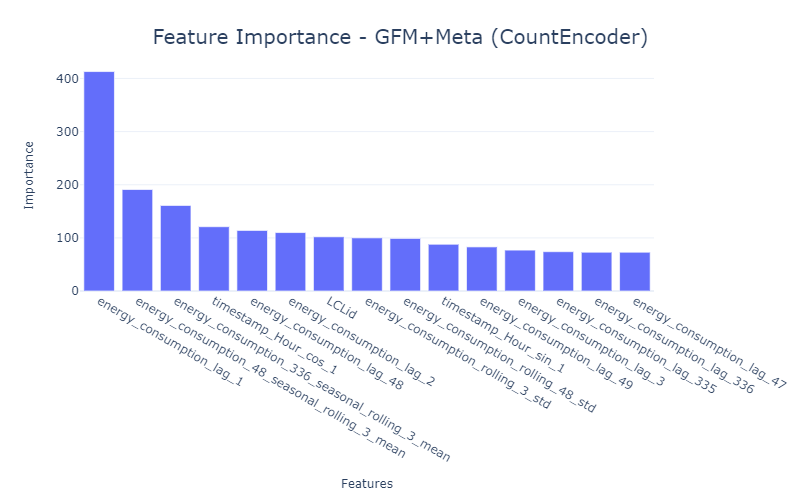

In [22]:
fig = px.bar(feat_df.head(15), x="feature", y="importance")
format_plot(fig, xlabel="Features", ylabel="Importance", title=f"Feature Importance - {model_config.name}", font_size=12)
fig.write_image("imgs/chapter_8/baseline_w_meta_cnt_encoder_fimp.png")
fig.show()

### Target Encoding

In [23]:
from category_encoders import TargetEncoder

In [24]:
from category_encoders import TargetEncoder
from lightgbm import LGBMRegressor

cat_encoder = TargetEncoder(cols=cat_features)

model_config = ModelConfig(
    model=LGBMRegressor(random_state=42),
    name="GFM+Meta  (TargetEncoder)",
    # LGBM is not sensitive to normalized data
    normalize=False,
    # LGBM can handle missing values
    fill_missing=False,
    encode_categorical=True,
    categorical_encoder=cat_encoder
)

In [25]:
with LogTime() as timer:
    y_pred, feat_df = train_model(
        model_config,
        _feat_config,
        missing_value_config,
        train_features,
        train_target,
        test_features,
    )
agg_metrics, eval_metrics_df = evaluate_forecast(y_pred, test_target, train_target, model_config)
agg_metrics["Time Elapsed"] = timer.elapsed
metric_record.append(agg_metrics)
individual_metrics[model_config.name]=eval_metrics_df
pred_df = pred_df.join(y_pred)

Time Elapsed: 43 seconds


Calculating metrics...:   0%|          | 0/150 [00:00<?, ?it/s]

In [26]:
pd.DataFrame(metric_record)

Algorithm       MAE       MSE  meanMASE  Forecast Bias  \
0                   LightGBM  0.077183  0.027510  0.978056       0.050231   
1               GFM Baseline  0.079581  0.027326  1.013393       0.218127   
2    GFM+Meta (CountEncoder)  0.079411  0.027233  1.011801       0.037475   
3  GFM+Meta  (TargetEncoder)  0.079537  0.027218  1.012400       0.335610   

   Time Elapsed  
0           NaN  
1     28.718087  
2     68.020298  
3     43.607325

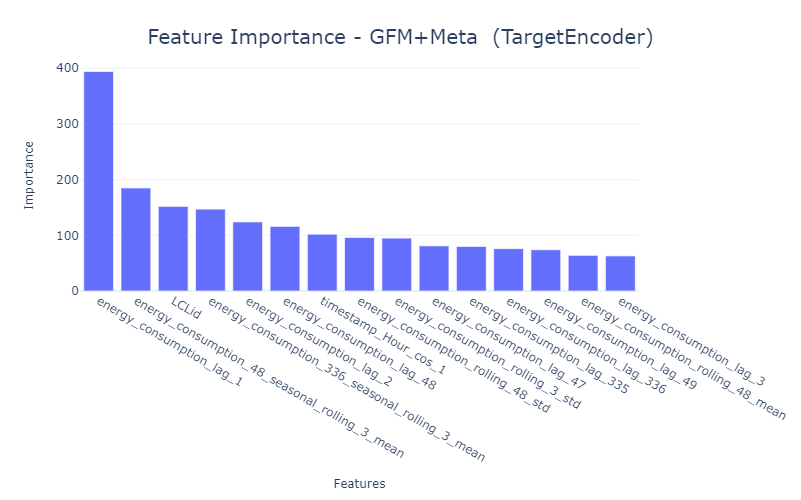

In [27]:
fig = px.bar(feat_df.head(15), x="feature", y="importance")
format_plot(fig, xlabel="Features", ylabel="Importance", title=f"Feature Importance - {model_config.name}", font_size=12)
fig.write_image("imgs/chapter_8/baseline_w_meta_tgt_encoder_fimp.png")
fig.show()

### Native LightGBM Encoding

In [28]:
from lightgbm import LGBMRegressor
model_config = ModelConfig(
    model=LGBMRegressor(random_state=42),
    name="GFM+Meta  (NativeLGBM)",
    # LGBM is not sensitive to normalized data
    normalize=False,
    # LGBM can handle missing values
    fill_missing=False,
    # We are using inbuilt categorical feature handling
    encode_categorical=False,
)

In [29]:
with LogTime() as timer:
    y_pred, feat_df = train_model(
        model_config,
        _feat_config,
        missing_value_config,
        train_features,
        train_target,
        test_features,
        fit_kwargs=dict(categorical_feature=cat_features),
    )
agg_metrics, eval_metrics_df = evaluate_forecast(y_pred, test_target, train_target, model_config)
agg_metrics["Time Elapsed"] = timer.elapsed
metric_record.append(agg_metrics)
individual_metrics[model_config.name]=eval_metrics_df
pred_df = pred_df.join(y_pred)

C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



Time Elapsed: 30 seconds


Calculating metrics...:   0%|          | 0/150 [00:00<?, ?it/s]

In [30]:
pd.DataFrame(metric_record)

Algorithm       MAE       MSE  meanMASE  Forecast Bias  \
0                   LightGBM  0.077183  0.027510  0.978056       0.050231   
1               GFM Baseline  0.079581  0.027326  1.013393       0.218127   
2    GFM+Meta (CountEncoder)  0.079411  0.027233  1.011801       0.037475   
3  GFM+Meta  (TargetEncoder)  0.079537  0.027218  1.012400       0.335610   
4     GFM+Meta  (NativeLGBM)  0.079209  0.027329  1.002630      -0.083755   

   Time Elapsed  
0           NaN  
1     28.718087  
2     68.020298  
3     43.607325  
4     30.316029

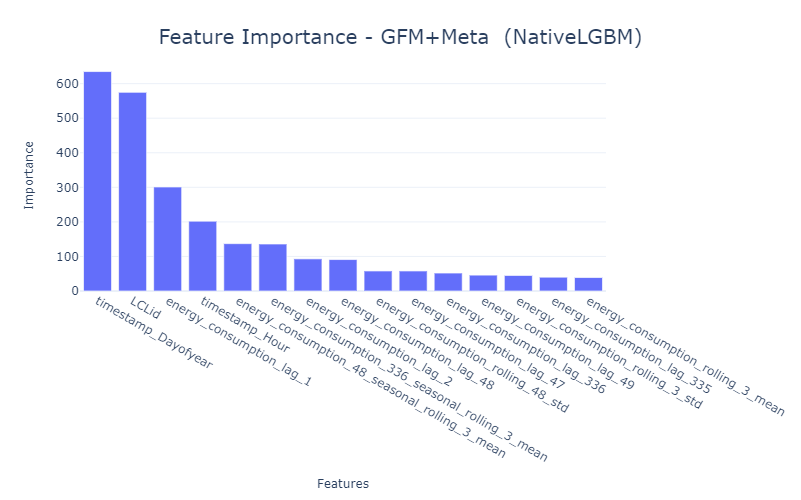

In [31]:
fig = px.bar(feat_df.head(15), x="feature", y="importance")
format_plot(fig, xlabel="Features", ylabel="Importance", title=f"Feature Importance - {model_config.name}", font_size=12)
fig.write_image("imgs/chapter_8/baseline_w_meta_native_lgbm_fimp.png")
fig.show()

## Hyperparameter Tuning

In [32]:
feat_conf_dict = copy.deepcopy(feat_config.__dict__)
feat_conf_dict.pop("feature_list")
feat_conf_dict['categorical_features']+=["stdorToU", "Acorn", "Acorn_grouped", "LCLid"]
_feat_config = FeatureConfig(**feat_conf_dict)

train_features, train_target, train_original_target = _feat_config.get_X_y(
    train_df, categorical=True, exogenous=False
)
# Loading the Validation as test
test_features, test_target, test_original_target = _feat_config.get_X_y(
    test_df, categorical=True, exogenous=False
)

cat_features = set(train_features.columns).intersection(_feat_config.categorical_features)

<div class="alert alert-block alert-warning"><b>Important: </b> Run the following cells for Hyperparameter Tuning only if needed. <br/>The best parameters are hardcoded in the section after the tuning so that these cells need not be run everytime (Takes a lot of time).<br/> Skip to <b>Using the tuned parameters</b></div>

### Grid Search

In [32]:
from sklearn.model_selection import ParameterGrid

grid_params = {
    "num_leaves": [16, 31, 63],
    "objective": ["regression", "regression_l1", "huber"],
    "random_state": [42],
    "colsample_bytree": [0.5, 0.8, 1.0],
}
parameter_space = list(ParameterGrid(grid_params))

In [34]:
# Can use PredefinedSplit along with GridSearchCV to have the search done faster using multi-processing
# Or we can parallelize the loop ourselves
scores = []
for p in tqdm(parameter_space, desc="Performing Grid Search"):
    _model_config = ModelConfig(
        model=LGBMRegressor(**p, verbose=-1),
        name="Global Meta LightGBM Tuning",
        # LGBM is not sensitive to normalized data
        normalize=False,
        # LGBM can handle missing values
        fill_missing=False,
    )
    y_pred, feat_df = train_model(
        _model_config,
        _feat_config,
        missing_value_config,
        train_features,
        train_target,
        test_features,
        fit_kwargs=dict(categorical_feature=cat_features),
    )
    scores.append(ts_utils.mae(
                test_target['energy_consumption'], y_pred
            ))
    

Performing Grid Search:   0%|          | 0/27 [00:00<?, ?it/s]

In [35]:
grid_search_trials = pd.DataFrame({"params":parameter_space, "score":scores}).sort_values("score")
best_params_gs = grid_search_trials.iloc[0,0]
best_score_gs = grid_search_trials.iloc[0,1]
grid_search_trials.head()

params     score
25  {'colsample_bytree': 1.0, 'num_leaves': 63, 'o...  0.073454
16  {'colsample_bytree': 0.8, 'num_leaves': 63, 'o...  0.073533
7   {'colsample_bytree': 0.5, 'num_leaves': 63, 'o...  0.074237
22  {'colsample_bytree': 1.0, 'num_leaves': 31, 'o...  0.074624
13  {'colsample_bytree': 0.8, 'num_leaves': 31, 'o...  0.074635

### Random Search

In [36]:
import scipy
from sklearn.model_selection import ParameterSampler

random_search_params = {
    # A uniform distribution between 10 and 100, but only integers
    "num_leaves": scipy.stats.randint(10,100),
    # A list of categorical string values
    "objective": ["regression", "regression_l1", "huber"],
    "random_state": [42],
    # List of floating point numbers between 0.3 and 1.0 with a resolution of 0.05
    "colsample_bytree": np.arange(0.3,1.0,0.05),
    # List of floating point numbers between 0 and 10 with a resolution of 0.1
    "lambda_l1":np.arange(0,10,0.1),
    # List of floating point numbers between 0 and 10 with a resolution of 0.1
    "lambda_l2":np.arange(0,10,0.1)
}
# Sampling from the search space number of iterations times
parameter_space = list(ParameterSampler(random_search_params, n_iter=27, random_state=42))

In [37]:
# Can use PredefinedSplit along with RandomSearchCV to have the search done faster using multi-processing
# Or we can parallelize the loop ourselves
scores = []
for p in tqdm(parameter_space, desc="Performing Random Search"):
    _model_config = ModelConfig(
        model=LGBMRegressor(**p, verbose=-1),
        name="Global Meta LightGBM Tuning",
        # LGBM is not sensitive to normalized data
        normalize=False,
        # LGBM can handle missing values
        fill_missing=False,
    )
    y_pred, feat_df = train_model(
        _model_config,
        _feat_config,
        missing_value_config,
        train_features,
        train_target,
        test_features,
        fit_kwargs=dict(categorical_feature=cat_features),
    )
    scores.append(ts_utils.mae(
                test_target['energy_consumption'], y_pred
            ))
    

Performing Random Search:   0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=5.1000000000000005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1000000000000005
[LightGBM] [Warning] lambda_l2 is set=9.200000000000001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.200000000000001
[LightGBM] [Warning] lambda_l1 is set=6.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.0
[LightGBM] [Warning] lambda_l2 is set=2.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0
[LightGBM] [Warning] lambda_l1 is set=7.4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.4
[LightGBM] [Warning] lambda_l2 is set=8.700000000000001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.700000000000001
[LightGBM] [Warning] lambda_l1 is set=5.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.2
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current valu

In [38]:
random_search_trials = pd.DataFrame({"params":parameter_space, "score":scores}).sort_values("score")
best_params_rs = random_search_trials.iloc[0,0]
best_score_rs = random_search_trials.iloc[0,1]
random_search_trials.head()

params     score
3   {'colsample_bytree': 0.5499999999999999, 'lamb...  0.073752
20  {'colsample_bytree': 0.8999999999999999, 'lamb...  0.074347
11  {'colsample_bytree': 0.35, 'lambda_l1': 0.3000...  0.075169
12  {'colsample_bytree': 0.35, 'lambda_l1': 0.8, '...  0.075242
17  {'colsample_bytree': 0.35, 'lambda_l1': 8.9, '...  0.075633

### Bayesian Optimization

In [39]:
import optuna

In [40]:
# Define an objective functions which takes in trial as a parameter 
# and evaluates the model with the generated params
def objective(trial):
    params = {
        # Sample an integer between 10 and 100
        "num_leaves": trial.suggest_int("num_leaves", 10, 100),
        # Sample a categorical value from the list provided
        "objective": trial.suggest_categorical(
            "objective", ["regression", "regression_l1", "huber"]
        ),
        "random_state": [42],
        # Sample from a uniform distribution between 0.3 and 1.0
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.3, 1.0),
        # Sample from a uniform distribution between 0 and 10
        "lambda_l1": trial.suggest_uniform("lambda_l1", 0, 10),
        # Sample from a uniform distribution between 0 and 10
        "lambda_l2": trial.suggest_uniform("lambda_l2", 0, 10),
    }
    _model_config = ModelConfig(
        # Use the sampled params to initialize the model
        model=LGBMRegressor(**params, verbose=-1),
        name="Global Meta LightGBM Tuning",
        # LGBM is not sensitive to normalized data
        normalize=False,
        # LGBM can handle missing values
        fill_missing=False,
    )
    y_pred, feat_df = train_model(
        _model_config,
        _feat_config,
        missing_value_config,
        train_features,
        train_target,
        test_features,
        fit_kwargs=dict(categorical_feature=cat_features),
    )
    # Return the MAE metric as the value
    return ts_utils.mae(test_target["energy_consumption"], y_pred)

In [41]:
# Create a sampler and set seed for repeatability. 
# Set startup trials as 5 because out total trials is lower.
sampler = optuna.samplers.TPESampler(n_startup_trials=5, seed=42)
# Create a study
study = optuna.create_study(direction="minimize", sampler=sampler)
# Start the optimization run
study.optimize(objective, n_trials=27, show_progress_bar=True)

[I 2022-01-07 14:04:10,945] A new study created in memory with name: no-name-89884033-b648-4ca6-928d-18eba0b1d70a
C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=1.5599452033620265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5599452033620265
[LightGBM] [Warning] lambda_l2 is set=0.5808361216819946, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5808361216819946
[I 2022-01-07 14:04:42,330] Trial 0 finished with value: 0.07935670335877867 and parameters: {'num_leaves': 44, 'objective': 'regression', 'colsample_bytree': 0.40921304830970556, 'lambda_l1': 1.5599452033620265, 'lambda_l2': 0.5808361216819946}. Best is trial 0 with value: 0.07935670335877867.


C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=8.324426408004218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.324426408004218
[LightGBM] [Warning] lambda_l2 is set=2.1233911067827616, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1233911067827616
[I 2022-01-07 14:05:43,866] Trial 1 finished with value: 0.07306458648332854 and parameters: {'num_leaves': 88, 'objective': 'regression_l1', 'colsample_bytree': 0.978936896513396, 'lambda_l1': 8.324426408004218, 'lambda_l2': 2.1233911067827616}. Best is trial 1 with value: 0.07306458648332854.


C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=2.9122914019804194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9122914019804194
[LightGBM] [Warning] lambda_l2 is set=6.118528947223795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.118528947223795
[I 2022-01-07 14:06:13,438] Trial 2 finished with value: 0.07896635663782015 and parameters: {'num_leaves': 26, 'objective': 'huber', 'colsample_bytree': 0.602361513049481, 'lambda_l1': 2.9122914019804194, 'lambda_l2': 6.118528947223795}. Best is trial 1 with value: 0.07306458648332854.


C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=1.9967378215835974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9967378215835974
[LightGBM] [Warning] lambda_l2 is set=5.142344384136116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.142344384136116
[I 2022-01-07 14:06:46,965] Trial 3 finished with value: 0.07920166986144873 and parameters: {'num_leaves': 22, 'objective': 'huber', 'colsample_bytree': 0.8496231729751094, 'lambda_l1': 1.9967378215835974, 'lambda_l2': 5.142344384136116}. Best is trial 1 with value: 0.07306458648332854.


C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=9.488855372533333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.488855372533333
[LightGBM] [Warning] lambda_l2 is set=9.656320330745594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.656320330745594
[I 2022-01-07 14:07:29,978] Trial 4 finished with value: 0.07518747966030086 and parameters: {'num_leaves': 63, 'objective': 'regression_l1', 'colsample_bytree': 0.3455361150896956, 'lambda_l1': 9.488855372533333, 'lambda_l2': 9.656320330745594}. Best is trial 1 with value: 0.07306458648332854.


C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=8.160098582954642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.160098582954642
[LightGBM] [Warning] lambda_l2 is set=0.17840888757497253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17840888757497253
[I 2022-01-07 14:08:36,422] Trial 5 finished with value: 0.072837674602699 and parameters: {'num_leaves': 99, 'objective': 'regression_l1', 'colsample_bytree': 0.9786759775515064, 'lambda_l1': 8.160098582954642, 'lambda_l2': 0.17840888757497253}. Best is trial 5 with value: 0.072837674602699.


C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=6.268836449065676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.268836449065676
[LightGBM] [Warning] lambda_l2 is set=2.941909397501167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.941909397501167
[I 2022-01-07 14:09:28,657] Trial 6 finished with value: 0.07302819097681212 and parameters: {'num_leaves': 92, 'objective': 'regression_l1', 'colsample_bytree': 0.7465802286477426, 'lambda_l1': 6.268836449065676, 'lambda_l2': 2.941909397501167}. Best is trial 5 with value: 0.072837674602699.


C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=5.356242640354898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.356242640354898
[LightGBM] [Warning] lambda_l2 is set=0.3094250901897339, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3094250901897339
[I 2022-01-07 14:10:05,008] Trial 7 finished with value: 0.07826611080066645 and parameters: {'num_leaves': 71, 'objective': 'regression', 'colsample_bytree': 0.9471933601215858, 'lambda_l1': 5.356242640354898, 'lambda_l2': 0.3094250901897339}. Best is trial 5 with value: 0.072837674602699.


C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=7.458713849013311, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.458713849013311
[LightGBM] [Warning] lambda_l2 is set=7.551886387297376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.551886387297376
[I 2022-01-07 14:10:50,596] Trial 8 finished with value: 0.0734415440442703 and parameters: {'num_leaves': 95, 'objective': 'regression_l1', 'colsample_bytree': 0.5858871498583587, 'lambda_l1': 7.458713849013311, 'lambda_l2': 7.551886387297376}. Best is trial 5 with value: 0.072837674602699.


C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=3.7749428538551757, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7749428538551757
[LightGBM] [Warning] lambda_l2 is set=3.4763343049658277, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4763343049658277
[I 2022-01-07 14:11:35,310] Trial 9 finished with value: 0.07414262528694104 and parameters: {'num_leaves': 43, 'objective': 'regression_l1', 'colsample_bytree': 0.7368392792051073, 'lambda_l1': 3.7749428538551757, 'lambda_l2': 3.4763343049658277}. Best is trial 5 with value: 0.072837674602699.


C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=9.80750718165524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.80750718165524
[LightGBM] [Warning] lambda_l2 is set=1.8724936224363826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8724936224363826
[I 2022-01-07 14:12:08,589] Trial 10 finished with value: 0.07814962609533911 and parameters: {'num_leaves': 78, 'objective': 'regression', 'colsample_bytree': 0.4856918643368296, 'lambda_l1': 9.80750718165524, 'lambda_l2': 1.8724936224363826}. Best is trial 5 with value: 0.072837674602699.


C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=6.266758472596477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.266758472596477
[LightGBM] [Warning] lambda_l2 is set=3.122349359221165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.122349359221165
[I 2022-01-07 14:13:06,481] Trial 11 finished with value: 0.07299330831039115 and parameters: {'num_leaves': 100, 'objective': 'regression_l1', 'colsample_bytree': 0.775571980986944, 'lambda_l1': 6.266758472596477, 'lambda_l2': 3.122349359221165}. Best is trial 5 with value: 0.072837674602699.


C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=6.9277355028712675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.9277355028712675
[LightGBM] [Warning] lambda_l2 is set=3.9693353851808757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9693353851808757
[I 2022-01-07 14:13:58,330] Trial 12 finished with value: 0.07289038661683253 and parameters: {'num_leaves': 100, 'objective': 'regression_l1', 'colsample_bytree': 0.8487966234497364, 'lambda_l1': 6.9277355028712675, 'lambda_l2': 3.9693353851808757}. Best is trial 5 with value: 0.072837674602699.


C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=7.810997956070779, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.810997956070779
[LightGBM] [Warning] lambda_l2 is set=7.049270826015108, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.049270826015108
[I 2022-01-07 14:14:53,259] Trial 13 finished with value: 0.0729492136030161 and parameters: {'num_leaves': 80, 'objective': 'regression_l1', 'colsample_bytree': 0.8803478855262776, 'lambda_l1': 7.810997956070779, 'lambda_l2': 7.049270826015108}. Best is trial 5 with value: 0.072837674602699.


C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=0.10989189243771325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10989189243771325
[LightGBM] [Warning] lambda_l2 is set=4.485480568900762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.485480568900762
[I 2022-01-07 14:15:46,007] Trial 14 finished with value: 0.07359077289689821 and parameters: {'num_leaves': 55, 'objective': 'regression_l1', 'colsample_bytree': 0.8656512534645389, 'lambda_l1': 0.10989189243771325, 'lambda_l2': 4.485480568900762}. Best is trial 5 with value: 0.072837674602699.


C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=6.669858915620237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.669858915620237
[LightGBM] [Warning] lambda_l2 is set=0.0474011965308927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0474011965308927
[I 2022-01-07 14:16:31,432] Trial 15 finished with value: 0.07738571537594176 and parameters: {'num_leaves': 81, 'objective': 'huber', 'colsample_bytree': 0.9994719350474364, 'lambda_l1': 6.669858915620237, 'lambda_l2': 0.0474011965308927}. Best is trial 5 with value: 0.072837674602699.


C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=4.778257400389069, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.778257400389069
[LightGBM] [Warning] lambda_l2 is set=9.468049264135633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.468049264135633
[I 2022-01-07 14:17:07,075] Trial 16 finished with value: 0.07676674813426536 and parameters: {'num_leaves': 11, 'objective': 'regression_l1', 'colsample_bytree': 0.8115822015200034, 'lambda_l1': 4.778257400389069, 'lambda_l2': 9.468049264135633}. Best is trial 5 with value: 0.072837674602699.


C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=8.193403055670656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.193403055670656
[LightGBM] [Warning] lambda_l2 is set=1.2263483602522036, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2263483602522036
[I 2022-01-07 14:17:58,850] Trial 17 finished with value: 0.07312221824355852 and parameters: {'num_leaves': 100, 'objective': 'regression_l1', 'colsample_bytree': 0.6671807109291792, 'lambda_l1': 8.193403055670656, 'lambda_l2': 1.2263483602522036}. Best is trial 5 with value: 0.072837674602699.


C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=8.957337939099776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.957337939099776
[LightGBM] [Warning] lambda_l2 is set=4.469992192608311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.469992192608311
[I 2022-01-07 14:18:39,864] Trial 18 finished with value: 0.07754641217164053 and parameters: {'num_leaves': 68, 'objective': 'huber', 'colsample_bytree': 0.9250388788829393, 'lambda_l1': 8.957337939099776, 'lambda_l2': 4.469992192608311}. Best is trial 5 with value: 0.072837674602699.


C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=4.959308449207034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.959308449207034
[LightGBM] [Warning] lambda_l2 is set=7.623854830055078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.623854830055078
[I 2022-01-07 14:19:21,192] Trial 19 finished with value: 0.0784471855519498 and parameters: {'num_leaves': 59, 'objective': 'regression', 'colsample_bytree': 0.6988240171788258, 'lambda_l1': 4.959308449207034, 'lambda_l2': 7.623854830055078}. Best is trial 5 with value: 0.072837674602699.


C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=7.020769245470003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.020769245470003
[LightGBM] [Warning] lambda_l2 is set=5.874147314000499, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.874147314000499
[I 2022-01-07 14:20:21,079] Trial 20 finished with value: 0.0728514032239969 and parameters: {'num_leaves': 89, 'objective': 'regression_l1', 'colsample_bytree': 0.8953531370720376, 'lambda_l1': 7.020769245470003, 'lambda_l2': 5.874147314000499}. Best is trial 5 with value: 0.072837674602699.


C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=6.733467046544348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.733467046544348
[LightGBM] [Warning] lambda_l2 is set=5.78850561530631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.78850561530631
[I 2022-01-07 14:21:21,362] Trial 21 finished with value: 0.07291943825460719 and parameters: {'num_leaves': 88, 'objective': 'regression_l1', 'colsample_bytree': 0.9085490422929592, 'lambda_l1': 6.733467046544348, 'lambda_l2': 5.78850561530631}. Best is trial 5 with value: 0.072837674602699.


C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=7.245797055317807, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.245797055317807
[LightGBM] [Warning] lambda_l2 is set=8.682270042463713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.682270042463713
[I 2022-01-07 14:22:17,714] Trial 22 finished with value: 0.07320208819974607 and parameters: {'num_leaves': 88, 'objective': 'regression_l1', 'colsample_bytree': 0.8095389706310125, 'lambda_l1': 7.245797055317807, 'lambda_l2': 8.682270042463713}. Best is trial 5 with value: 0.072837674602699.


C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=5.647304025311301, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.647304025311301
[LightGBM] [Warning] lambda_l2 is set=6.401681836922955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.401681836922955
[I 2022-01-07 14:23:21,146] Trial 23 finished with value: 0.07294974101943313 and parameters: {'num_leaves': 96, 'objective': 'regression_l1', 'colsample_bytree': 0.9371806444342191, 'lambda_l1': 5.647304025311301, 'lambda_l2': 6.401681836922955}. Best is trial 5 with value: 0.072837674602699.


C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=8.979228182015826, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.979228182015826
[LightGBM] [Warning] lambda_l2 is set=3.815341084988878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.815341084988878
[I 2022-01-07 14:24:14,561] Trial 24 finished with value: 0.07319247011085026 and parameters: {'num_leaves': 75, 'objective': 'regression_l1', 'colsample_bytree': 0.8275054114129193, 'lambda_l1': 8.979228182015826, 'lambda_l2': 3.815341084988878}. Best is trial 5 with value: 0.072837674602699.


C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=4.299745589163555, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.299745589163555
[LightGBM] [Warning] lambda_l2 is set=5.228093095730703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.228093095730703
[I 2022-01-07 14:25:18,366] Trial 25 finished with value: 0.07305959792405237 and parameters: {'num_leaves': 84, 'objective': 'regression_l1', 'colsample_bytree': 0.9905022983665313, 'lambda_l1': 4.299745589163555, 'lambda_l2': 5.228093095730703}. Best is trial 5 with value: 0.072837674602699.


C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=8.624808991805708, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.624808991805708
[LightGBM] [Warning] lambda_l2 is set=2.3536652308037205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3536652308037205
[I 2022-01-07 14:26:21,739] Trial 26 finished with value: 0.0730577509534919 and parameters: {'num_leaves': 100, 'objective': 'regression_l1', 'colsample_bytree': 0.8870712522698302, 'lambda_l1': 8.624808991805708, 'lambda_l2': 2.3536652308037205}. Best is trial 5 with value: 0.072837674602699.


In [42]:
bo_search_trials = study.trials_dataframe()
best_params_bo = study.best_params
best_score_bo = study.best_value
bo_search_trials.sort_values("value").head()

number     value             datetime_start          datetime_complete  \
5        5  0.072838 2022-01-07 14:07:29.991869 2022-01-07 14:08:36.421412   
20      20  0.072851 2022-01-07 14:19:21.235383 2022-01-07 14:20:21.072737   
12      12  0.072890 2022-01-07 14:13:06.522434 2022-01-07 14:13:58.329468   
21      21  0.072919 2022-01-07 14:20:21.122788 2022-01-07 14:21:21.351962   
13      13  0.072949 2022-01-07 14:13:58.333468 2022-01-07 14:14:53.258918   

                 duration  params_colsample_bytree  params_lambda_l1  \
5  0 days 00:01:06.429543                 0.978676          8.160099   
20 0 days 00:00:59.837354                 0.895353          7.020769   
12 0 days 00:00:51.807034                 0.848797          6.927736   
21 0 days 00:01:00.229174                 0.908549          6.733467   
13 0 days 00:00:54.925450                 0.880348          7.810998   

    params_lambda_l2  params_num_leaves params_objective     state  
5           0.178409                 99    regression_l1  COMPLETE  
20          5.874147                 89    regression_l1  COMPLETE  
12          3.969335                100    regression_l1  COMPLETE  
21          5.788506                 88    regression_l1  COMPLETE  
13          7.049271                 80    regression_l1  COMPLETE

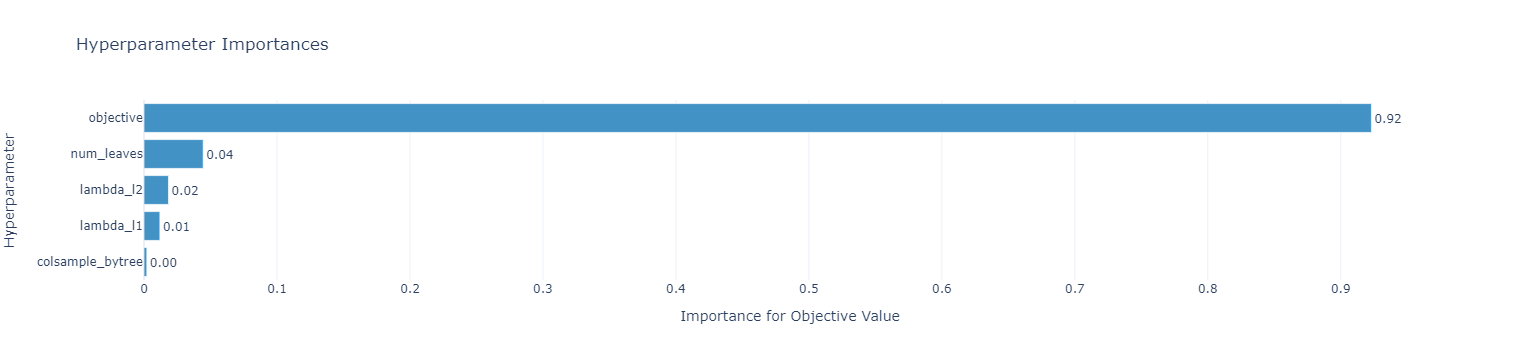

In [43]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

### Hyperparameter Tuning Techniques (Comparison)

In [44]:
def plot_optimization_history(trials_df):
    plot_df = trials_df.sort_index()
    plot_df['best'] = plot_df.score.expanding().min()

    x = plot_df.reset_index().index
    fig = go.Figure(layout=dict(title="Optimization History Plot"))

    fig.add_trace(
        go.Scatter(
            x=x,
            y=plot_df.score,
            mode='markers',
            name="Objective"
        ))

    fig.add_trace(
        go.Scatter(
            x=x,
            y=plot_df.best,
            mode='lines',
            name="Best Value"
        ))

    return fig

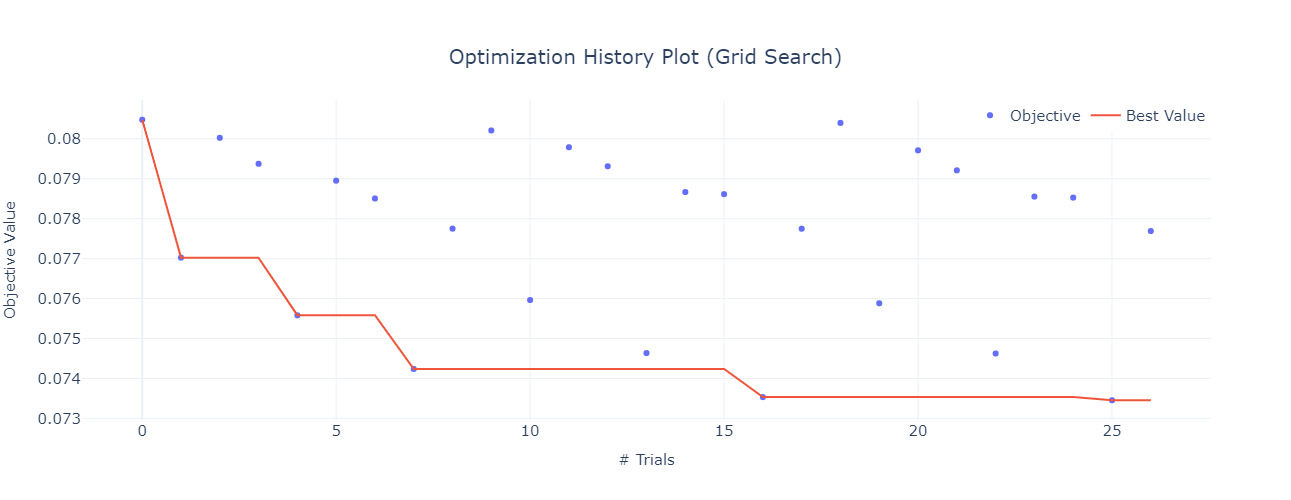

In [45]:
fig = plot_optimization_history(grid_search_trials)
fig = format_plot(fig, xlabel="# Trials", ylabel="Objective Value", title="Optimization History Plot (Grid Search)")
fig.write_image("imgs/chapter_8/opt_history_gs.png")
fig.show()

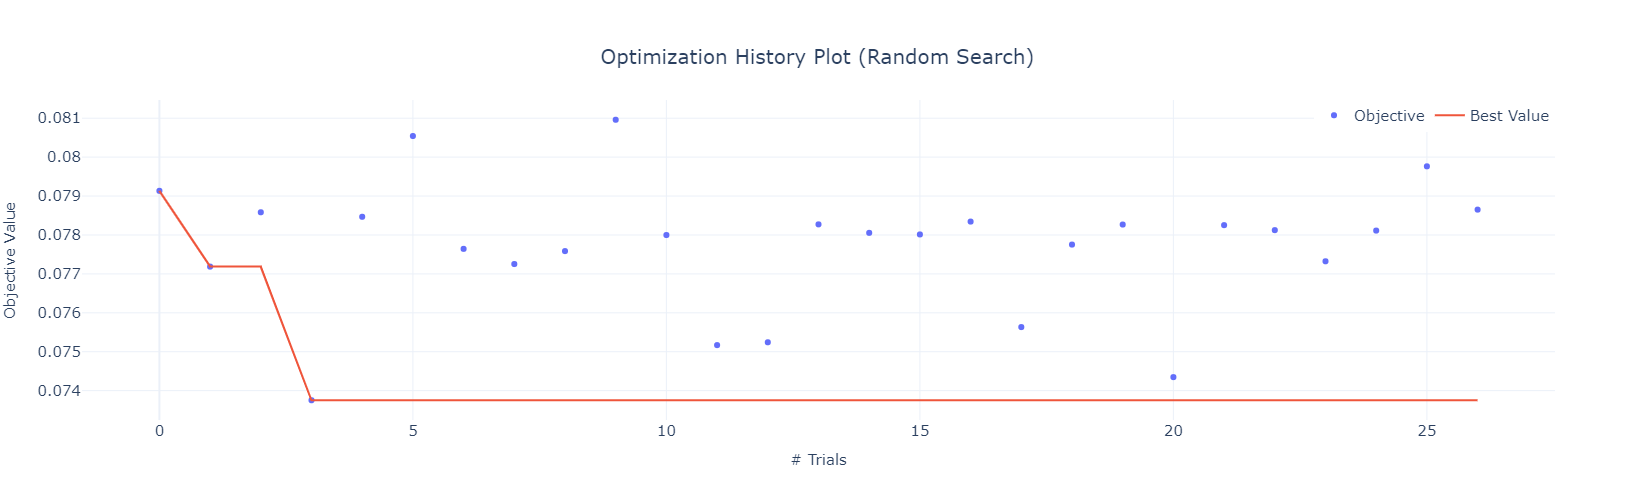

In [46]:
fig = plot_optimization_history(random_search_trials)
fig = format_plot(fig, xlabel="# Trials", ylabel="Objective Value", title="Optimization History Plot (Random Search)")
fig.write_image("imgs/chapter_8/opt_history_rs.png")
fig.show()

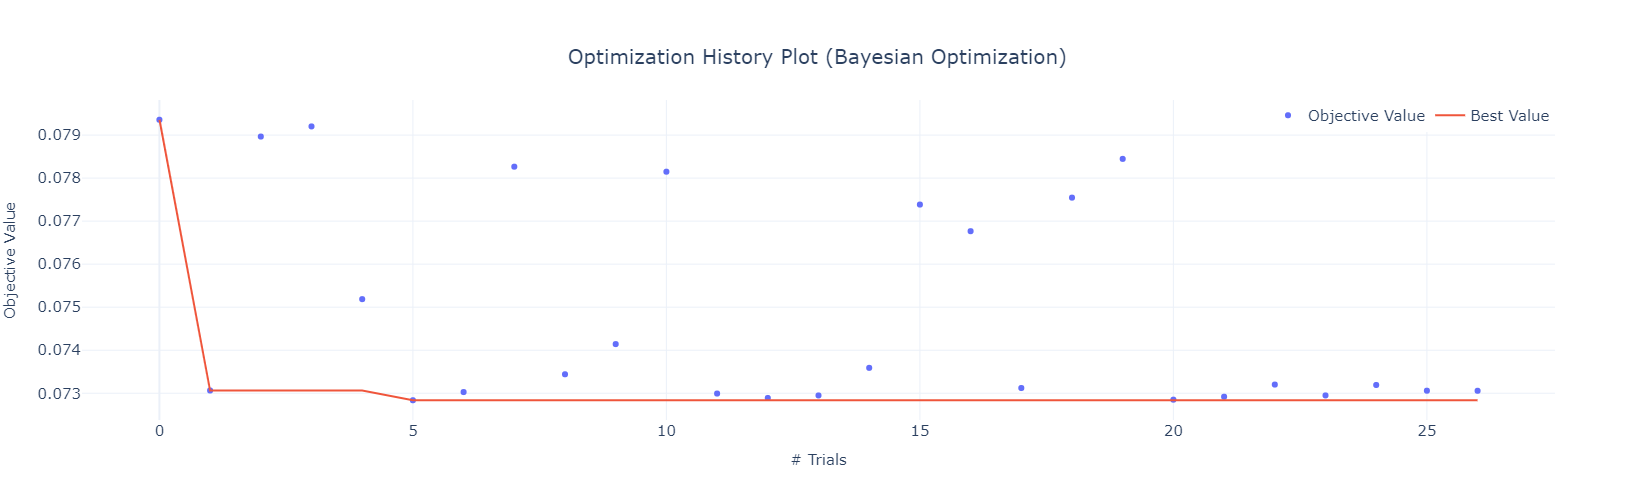

In [47]:
fig = optuna.visualization.plot_optimization_history(study)
fig = format_plot(fig, xlabel="# Trials", ylabel="Objective Value", title="Optimization History Plot (Bayesian Optimization)")
fig.write_image("imgs/chapter_8/opt_history_bo.png")
fig.show()

This makes the distinction clearer. Grid Search has a pattern which indicates that it is just executing the defined trials blindly in the order it was given. Even after seeing a particular region is of low value, it still executes those trials because it is not self-aware. Random Search is pretty much what we expected. We can see that the objective values are also pretty randomly distributed and even towards the end, it is still exploring low value regions in the search space. But Bayesian Optimization can be seen to improve the objective value and focus most of its trials on regions which gives best objective value.

In [48]:
plot_df = pd.DataFrame({"Optimization": ["Grid Search", "Random Search", "Bayesian Optimization"], "Best Score": [best_score_gs, best_score_rs, best_score_bo]}).sort_values(by = ['Best Score'],
                    ascending = True)
plot_df

Optimization  Best Score
2  Bayesian Optimization    0.072838
0            Grid Search    0.073454
1          Random Search    0.073752

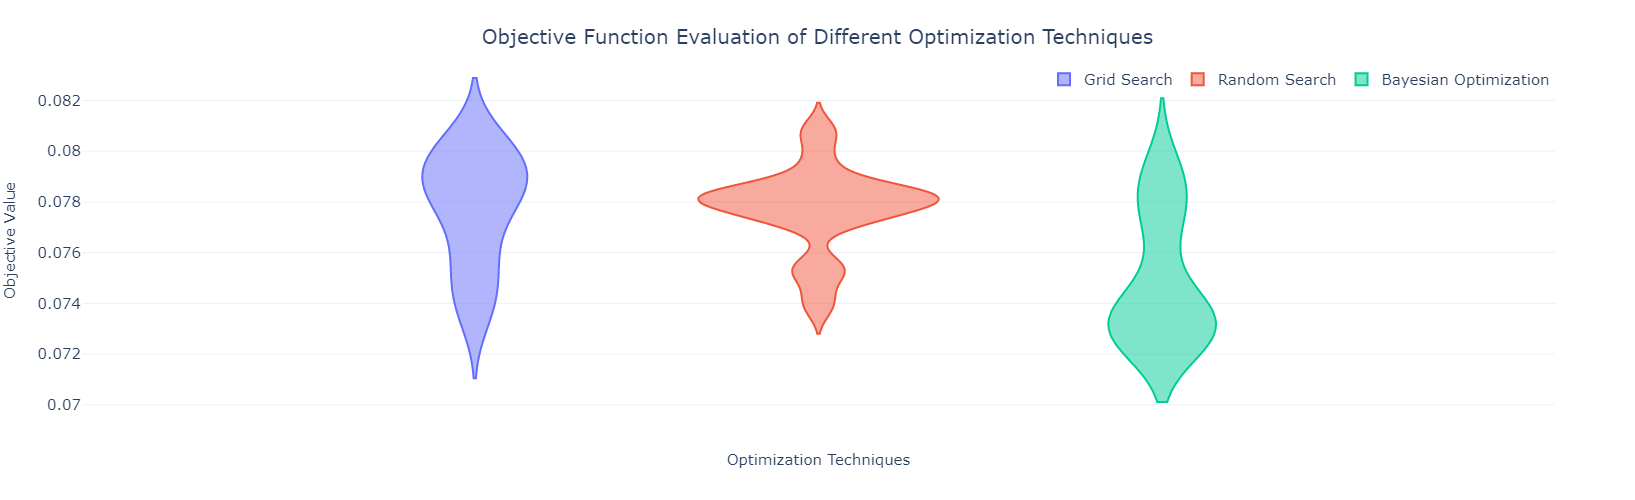

In [49]:
plot_df = grid_search_trials.copy()
plot_df['optimization'] = "Grid Search"
plot_df.drop(columns="params", inplace=True)

df_ = random_search_trials.copy()
df_['optimization'] = "Random Search"
df_.drop(columns="params", inplace=True)
plot_df = pd.concat([plot_df, df_])

df_ = bo_search_trials.copy()
df_['optimization'] = "Bayesian Optimization"
df_.rename(columns={"value": "score"}, inplace=True)
df_ = df_[["score", "optimization"]]
plot_df = pd.concat([plot_df, df_])

fig = px.violin(plot_df, y="score", color="optimization",  points=False)
fig = format_plot(fig, xlabel="Optimization Techniques", ylabel="Objective Value", title="Objective Function Evaluation of Different Optimization Techniques")
fig.write_image("imgs/chapter_8/opt_violin.png")
fig.show()

We can see that the Bayesian Optimization has a fat tail on the lower side indicating that it spent most of its computational budget evaluating and exploiting optimal regions of the search space. 

<a id="using_tuned_parameters"></a>
### Using the tuned parameters

In [50]:
# best_params = study.best_params
# best_params['random_state'] = 42
# best_params

{'num_leaves': 99,
 'objective': 'regression_l1',
 'colsample_bytree': 0.9786759775515064,
 'lambda_l1': 8.160098582954642,
 'lambda_l2': 0.17840888757497253,
 'random_state': 42}

In [33]:
best_params = {
    "num_leaves": 99,
    "objective": "regression_l1",
    "colsample_bytree": 0.9786759775515064,
    "lambda_l1": 8.160098582954642,
    "lambda_l2": 0.17840888757497253,
    "random_state": 42,
}

In [34]:
from lightgbm import LGBMRegressor
model_config = ModelConfig(
    model=LGBMRegressor(**best_params),
    name="Tuned GFM+Meta",
    # LGBM is not sensitive to normalized data
    normalize=False,
    # LGBM can handle missing values
    fill_missing=False,
)

In [35]:
with LogTime() as timer:
    y_pred, feat_df = train_model(
        model_config,
        _feat_config,
        missing_value_config,
        train_features,
        train_target,
        test_features,
        fit_kwargs=dict(categorical_feature=cat_features)
    )
agg_metrics, eval_metrics_df = evaluate_forecast(y_pred, test_target, train_target, model_config)
agg_metrics["Time Elapsed"] = timer.elapsed
metric_record.append(agg_metrics)
individual_metrics[model_config.name]=eval_metrics_df
pred_df = pred_df.join(y_pred)

C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=8.160098582954642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.160098582954642
[LightGBM] [Warning] lambda_l2 is set=0.17840888757497253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17840888757497253
Time Elapsed: 57 seconds


Calculating metrics...:   0%|          | 0/150 [00:00<?, ?it/s]

In [36]:
pd.DataFrame(metric_record)

Algorithm       MAE       MSE  meanMASE  Forecast Bias  \
0                   LightGBM  0.077183  0.027510  0.978056       0.050231   
1               GFM Baseline  0.079581  0.027326  1.013393       0.218127   
2    GFM+Meta (CountEncoder)  0.079411  0.027233  1.011801       0.037475   
3  GFM+Meta  (TargetEncoder)  0.079537  0.027218  1.012400       0.335610   
4     GFM+Meta  (NativeLGBM)  0.079209  0.027329  1.002630      -0.083755   
5             Tuned GFM+Meta  0.072918  0.030641  0.900749     -12.412786   

   Time Elapsed  
0           NaN  
1     28.718087  
2     68.020298  
3     43.607325  
4     30.316029  
5     57.936451

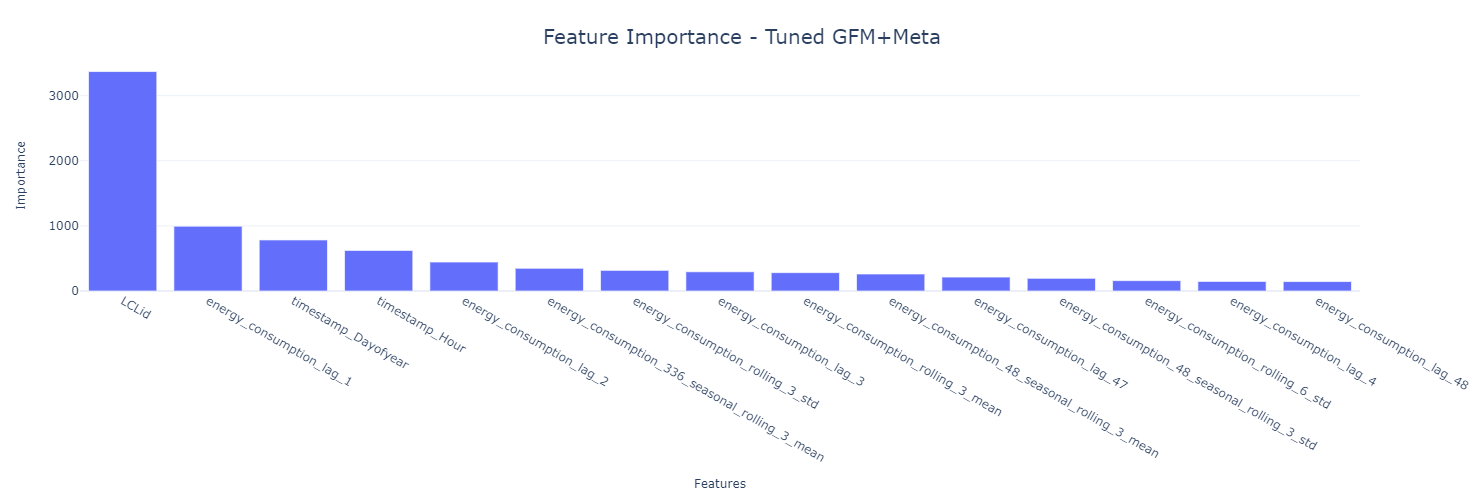

In [37]:
fig = px.bar(feat_df.head(15), x="feature", y="importance")
format_plot(fig, xlabel="Features", ylabel="Importance", title=f"Feature Importance - {model_config.name}", font_size=12)
fig.write_image("imgs/chapter_8/tuned_meta_fimp.png")
fig.show()

## Partitioning

In [13]:
best_params = {
    "num_leaves": 99,
    "objective": "regression_l1",
    "colsample_bytree": 0.9786759775515064,
    "lambda_l1": 8.160098582954642,
    "lambda_l2": 0.17840888757497253,
    "random_state": 42,
}

### Random

We can partition Randomly

In [39]:
feat_conf_dict = copy.deepcopy(feat_config.__dict__)
feat_conf_dict.pop("feature_list")
feat_conf_dict['categorical_features']+=["stdorToU", "Acorn", "LCLid", "Acorn_grouped"]
_feat_config = FeatureConfig(**feat_conf_dict)

In [40]:
from lightgbm import LGBMRegressor
model_config = ModelConfig(
    model=LGBMRegressor(**best_params, verbose=-1),
    name="Tuned GFM+Meta+Random Part",
    # LGBM is not sensitive to normalized data
    normalize=False,
    # LGBM can handle missing values
    fill_missing=False,
)

In [41]:
def partition (list_in, n):
    random.shuffle(list_in)
    return [list_in[i::n] for i in range(n)]

partitions = partition(train_df.LCLid.cat.categories.tolist(), 3)

In [42]:
y_pred_l = []
feat_df_l = []
time_elapsed_l = []
for lclids in tqdm(partitions, desc="Training groups..."):
    _train_df = train_df.loc[train_df.LCLid.isin(lclids)]
    _test_df = test_df.loc[test_df.LCLid.isin(lclids)]
    train_features, train_target, train_original_target = _feat_config.get_X_y(
        _train_df, categorical=True, exogenous=False
    )
    # Loading the Validation as test
    test_features, test_target, test_original_target = _feat_config.get_X_y(
        _test_df, categorical=True, exogenous=False
    )
    cat_features = set(train_features.columns).intersection(
        _feat_config.categorical_features
    )
    _model_config = model_config.clone()
    with LogTime() as timer:
        y_pred, feat_df = train_model(
            _model_config,
            _feat_config,
            missing_value_config,
            train_features,
            train_target,
            test_features,
            fit_kwargs=dict(categorical_feature=cat_features),
        )
    y_pred_l.append(y_pred)
    feat_df_l.append(feat_df)
    time_elapsed_l.append(timer.elapsed)

Training groups...:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=8.160098582954642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.160098582954642
[LightGBM] [Warning] lambda_l2 is set=0.17840888757497253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17840888757497253
Time Elapsed: 16 seconds
[LightGBM] [Warning] lambda_l1 is set=8.160098582954642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.160098582954642
[LightGBM] [Warning] lambda_l2 is set=0.17840888757497253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17840888757497253
Time Elapsed: 17 seconds
[LightGBM] [Warning] lambda_l1 is set=8.160098582954642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.160098582954642
[LightGBM] [Warning] lambda_l2 is set=0.17840888757497253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17840888757497253
Time Elapsed: 15 seconds


In [43]:
y_pred = pd.concat(y_pred_l)

test_features, test_target, test_original_target = _feat_config.get_X_y(
    test_df, categorical=True, exogenous=False
)
train_features, train_target, train_original_target = _feat_config.get_X_y(
    train_df, categorical=True, exogenous=False
)

agg_metrics, eval_metrics_df = evaluate_forecast(y_pred, test_target, train_target, model_config)
agg_metrics["Time Elapsed"] = np.sum(time_elapsed_l)
metric_record.append(agg_metrics)
individual_metrics[model_config.name]=eval_metrics_df
pred_df = pred_df.join(y_pred)

Calculating metrics...:   0%|          | 0/150 [00:00<?, ?it/s]

In [44]:
pd.DataFrame(metric_record)

Algorithm       MAE       MSE  meanMASE  Forecast Bias  \
0                    LightGBM  0.077183  0.027510  0.978056       0.050231   
1                GFM Baseline  0.079581  0.027326  1.013393       0.218127   
2     GFM+Meta (CountEncoder)  0.079411  0.027233  1.011801       0.037475   
3   GFM+Meta  (TargetEncoder)  0.079537  0.027218  1.012400       0.335610   
4      GFM+Meta  (NativeLGBM)  0.079209  0.027329  1.002630      -0.083755   
5              Tuned GFM+Meta  0.072918  0.030641  0.900749     -12.412786   
6  Tuned GFM+Meta+Random Part  0.072598  0.030681  0.898618     -12.361642   

   Time Elapsed  
0           NaN  
1     28.718087  
2     68.020298  
3     43.607325  
4     30.316029  
5     57.936451  
6     49.178089

In [45]:
#Averaging feature importance across partitions (Dirty Approximation)
feat_df = feat_df_l.pop(0)
for i, d in enumerate(feat_df_l):
    feat_df = feat_df.merge(d, on="feature",suffixes=("","_{i}"))

feat_df["importance"] = feat_df.sum(axis=1)
feat_df = feat_df.loc[:, ["feature", "importance"]]

C:\Users\MANUJO~1\AppData\Local\Temp/ipykernel_28916/1524127928.py:6: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



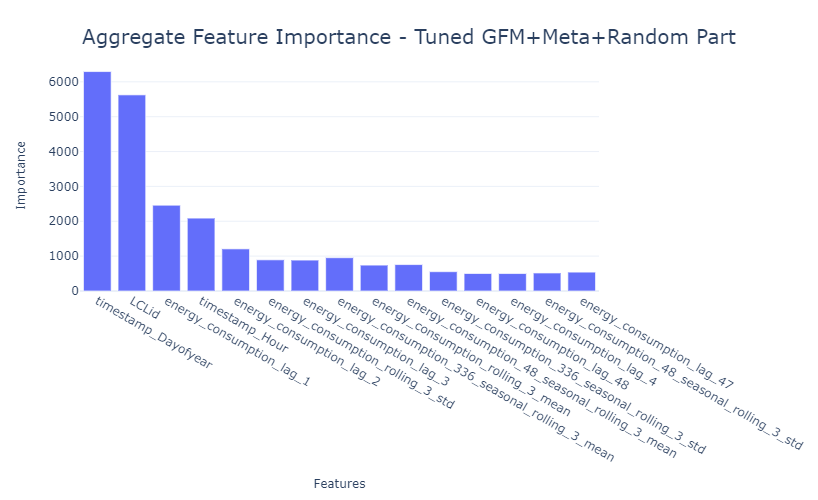

In [46]:
fig = px.bar(feat_df.head(15), x="feature", y="importance")
format_plot(fig, xlabel="Features", ylabel="Importance", title=f"Aggregate Feature Importance - {model_config.name}", font_size=12)
fig.write_image("imgs/chapter_8/random_partition_fimp.png")
fig.show()

### Judgmental

We can partition based on ACORN Groups

In [47]:
feat_conf_dict = copy.deepcopy(feat_config.__dict__)
feat_conf_dict.pop("feature_list")
feat_conf_dict['categorical_features']+=["stdorToU", "Acorn", "LCLid"]
_feat_config = FeatureConfig(**feat_conf_dict)

In [48]:
from lightgbm import LGBMRegressor
model_config = ModelConfig(
    model=LGBMRegressor(**best_params, verbose=-1),
    name="Tuned GFM+Meta+ACORN Part",
    # LGBM is not sensitive to normalized data
    normalize=False,
    # LGBM can handle missing values
    fill_missing=False,
)

In [49]:
y_pred_l = []
feat_df_l = []
time_elapsed_l = []
for acn in tqdm(train_df["Acorn_grouped"].unique(), desc="Training groups..."):
    _train_df = train_df.loc[train_df.Acorn_grouped == acn]
    _test_df = test_df.loc[test_df.Acorn_grouped == acn]
    train_features, train_target, train_original_target = _feat_config.get_X_y(
        _train_df, categorical=True, exogenous=False
    )
    # Loading the Validation as test
    test_features, test_target, test_original_target = _feat_config.get_X_y(
        _test_df, categorical=True, exogenous=False
    )
    cat_features = set(train_features.columns).intersection(
        _feat_config.categorical_features
    )
    _model_config = model_config.clone()
    with LogTime() as timer:
        y_pred, feat_df = train_model(
            _model_config,
            _feat_config,
            missing_value_config,
            train_features,
            train_target,
            test_features,
            fit_kwargs=dict(categorical_feature=cat_features),
        )
    y_pred_l.append(y_pred)
    feat_df_l.append(feat_df)
    time_elapsed_l.append(timer.elapsed)

Training groups...:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=8.160098582954642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.160098582954642
[LightGBM] [Warning] lambda_l2 is set=0.17840888757497253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17840888757497253
Time Elapsed: 15 seconds
[LightGBM] [Warning] lambda_l1 is set=8.160098582954642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.160098582954642
[LightGBM] [Warning] lambda_l2 is set=0.17840888757497253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17840888757497253
Time Elapsed: 15 seconds
[LightGBM] [Warning] lambda_l1 is set=8.160098582954642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.160098582954642
[LightGBM] [Warning] lambda_l2 is set=0.17840888757497253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17840888757497253
Time Elapsed: 20 seconds


In [50]:
y_pred = pd.concat(y_pred_l)

test_features, test_target, test_original_target = _feat_config.get_X_y(
    test_df, categorical=True, exogenous=False
)
train_features, train_target, train_original_target = _feat_config.get_X_y(
    train_df, categorical=True, exogenous=False
)

agg_metrics, eval_metrics_df = evaluate_forecast(y_pred, test_target, train_target, model_config)
agg_metrics["Time Elapsed"] = np.sum(time_elapsed_l)
metric_record.append(agg_metrics)
individual_metrics[model_config.name]=eval_metrics_df
pred_df = pred_df.join(y_pred)

Calculating metrics...:   0%|          | 0/150 [00:00<?, ?it/s]

In [51]:
pd.DataFrame(metric_record)

Algorithm       MAE       MSE  meanMASE  Forecast Bias  \
0                    LightGBM  0.077183  0.027510  0.978056       0.050231   
1                GFM Baseline  0.079581  0.027326  1.013393       0.218127   
2     GFM+Meta (CountEncoder)  0.079411  0.027233  1.011801       0.037475   
3   GFM+Meta  (TargetEncoder)  0.079537  0.027218  1.012400       0.335610   
4      GFM+Meta  (NativeLGBM)  0.079209  0.027329  1.002630      -0.083755   
5              Tuned GFM+Meta  0.072918  0.030641  0.900749     -12.412786   
6  Tuned GFM+Meta+Random Part  0.072598  0.030681  0.898618     -12.361642   
7   Tuned GFM+Meta+ACORN Part  0.072567  0.030786  0.898071     -12.316822   

   Time Elapsed  
0           NaN  
1     28.718087  
2     68.020298  
3     43.607325  
4     30.316029  
5     57.936451  
6     49.178089  
7     52.118687

In [52]:
#Averaging feature importance across partitions (Dirty Approximation)
feat_df = feat_df_l.pop(0)
for i, d in enumerate(feat_df_l):
    feat_df = feat_df.merge(d, on="feature",suffixes=("","_{i}"))

feat_df["importance"] = feat_df.sum(axis=1)
feat_df = feat_df.loc[:, ["feature", "importance"]]

C:\Users\MANUJO~1\AppData\Local\Temp/ipykernel_28916/1524127928.py:6: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



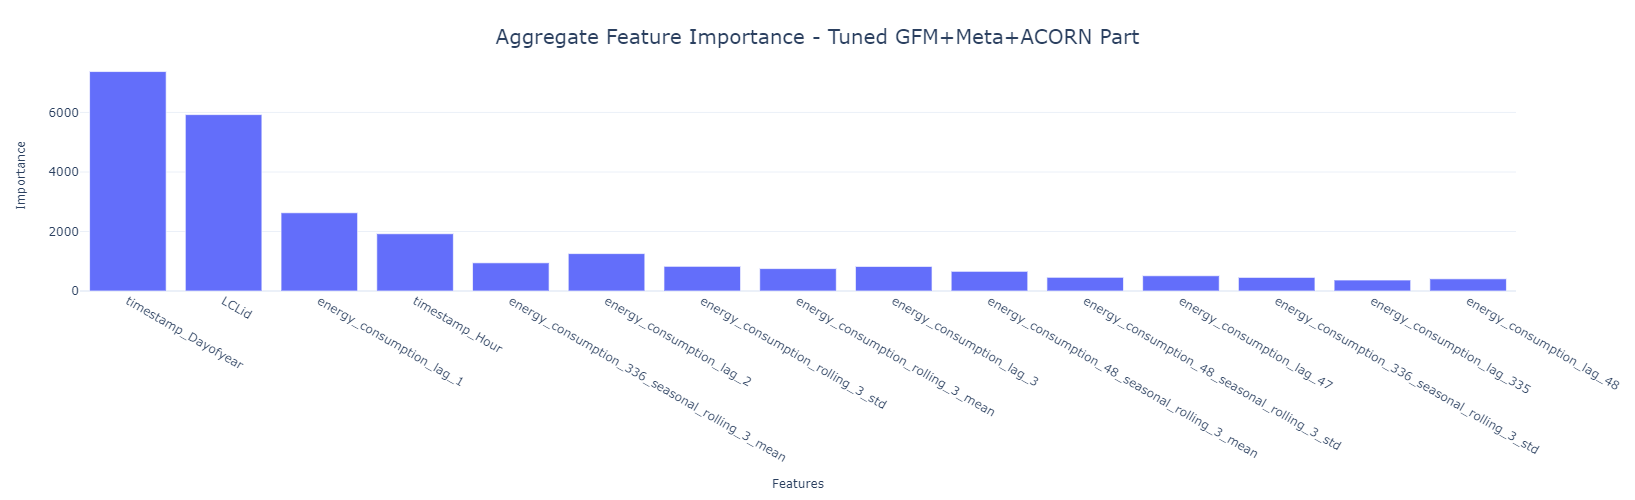

In [53]:
fig = px.bar(feat_df.head(15), x="feature", y="importance")
format_plot(fig, xlabel="Features", ylabel="Importance", title=f"Aggregate Feature Importance - {model_config.name}", font_size=12)
fig.write_image("imgs/chapter_8/acorn_partition_fimp.png")
fig.show()

### Algorithmic

In [14]:
feat_conf_dict = copy.deepcopy(feat_config.__dict__)
feat_conf_dict.pop("feature_list")
feat_conf_dict['categorical_features']+=["stdorToU", "Acorn", "LCLid", "Acorn_grouped"]
_feat_config = FeatureConfig(**feat_conf_dict)

#### Creating Statistical Features for the different households

In [15]:
import tsfel
cfg = tsfel.get_features_by_domain("statistical")
cfg = {**cfg, **tsfel.get_features_by_domain("temporal")}

uniq_ids = train_df.LCLid.cat.categories

stat_df = []
for id_ in tqdm(uniq_ids, desc="Calculating features for all households"):
    ts = train_df.loc[train_df.LCLid==id_, "energy_consumption"]
    res = tsfel.time_series_features_extractor(cfg, ts, verbose=False)
    res['LCLid'] = id_
    stat_df.append(res)

stat_df = pd.concat(stat_df).set_index("LCLid")
del res
stat_df.head()

Calculating features for all households:   0%|          | 0/150 [00:00<?, ?it/s]

C:\Users\MANUJO~1\AppData\Local\Temp/ipykernel_12052/2674221842.py:10: UserWarning: Using default sampling frequency set in configuration file.
  res = tsfel.time_series_features_extractor(cfg, ts, verbose=False)


0_ECDF_0  0_ECDF_1  0_ECDF_2  0_ECDF_3  0_ECDF_4  0_ECDF_5  \
LCLid                                                                   
MAC000061  0.000028  0.000057  0.000085  0.000114  0.000142  0.000171   
MAC000062  0.000028  0.000057  0.000085  0.000114  0.000142  0.000171   
MAC000066  0.000028  0.000057  0.000085  0.000114  0.000142  0.000171   
MAC000086  0.000028  0.000057  0.000085  0.000114  0.000142  0.000171   
MAC000126  0.000028  0.000057  0.000085  0.000114  0.000142  0.000171   

           0_ECDF_6  0_ECDF_7  0_ECDF_8  0_ECDF_9  ...  0_Median diff  \
LCLid                                              ...                  
MAC000061  0.000199  0.000228  0.000256  0.000285  ...          0.000   
MAC000062  0.000199  0.000228  0.000256  0.000285  ...         -0.003   
MAC000066  0.000199  0.000228  0.000256  0.000285  ...          0.000   
MAC000086  0.000199  0.000228  0.000256  0.000285  ...         -0.002   
MAC000126  0.000199  0.000228  0.000256  0.000285  ...         -0.002   

           0_Negative turning points  0_Neighbourhood peaks  \
LCLid                                                         
MAC000061                     7923.0                 1356.0   
MAC000062                    11613.0                 1534.0   
MAC000066                    11108.0                 1214.0   
MAC000086                    10432.0                 1561.0   
MAC000126                    10952.0                 1463.0   

           0_Peak to peak distance  0_Positive turning points  \
LCLid                                                           
MAC000061                 1.152000                     7989.0   
MAC000062                 2.655000                    11613.0   
MAC000066                 1.935000                    10943.0   
MAC000086                 1.820000                    10518.0   
MAC000126                 2.005673                    11023.0   

           0_Signal distance       0_Slope  0_Sum absolute diff  \
LCLid                                                             
MAC000061       35156.343443  1.339344e-07          1226.050345   
MAC000062       35374.532035  1.153972e-06          2641.711059   
MAC000066       35227.173610  8.020245e-08          1355.027212   
MAC000086       35457.316250  4.580171e-07          3015.591537   
MAC000126       35386.910614 -3.559724e-07          2314.231594   

           0_Total energy  0_Zero crossing rate  
LCLid                                            
MAC000061        2.426102                 106.0  
MAC000062        7.489917                   0.0  
MAC000066        3.201352                   0.0  
MAC000086        3.542938                   0.0  
MAC000126        3.707055                1068.0  

[5 rows x 54 columns]

#### Clustering the different households

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from src.utils.data_utils import replace_array_in_dataframe
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding

In [17]:
# Standardizing to make distance calculation fair
X_std = replace_array_in_dataframe(stat_df, StandardScaler().fit_transform(stat_df))
#Non-Linear Dimensionality Reduction
tsne = TSNE(n_components=2, perplexity=50, learning_rate="auto", init="pca", random_state=42, metric="cosine", square_distances=True)
X_tsne = tsne.fit_transform(X_std.values)
# Clustering reduced dimensions into 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42).fit(X_tsne)
cluster_df = pd.Series(kmeans.labels_, index=X_std.index)

C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [18]:
plot_df = pd.DataFrame(X_tsne, columns=["dim_1", "dim_2"], index=stat_df.index).reset_index()
plot_df["clusters"] = kmeans.labels_
plot_df["clusters"] = plot_df["clusters"].astype(str)

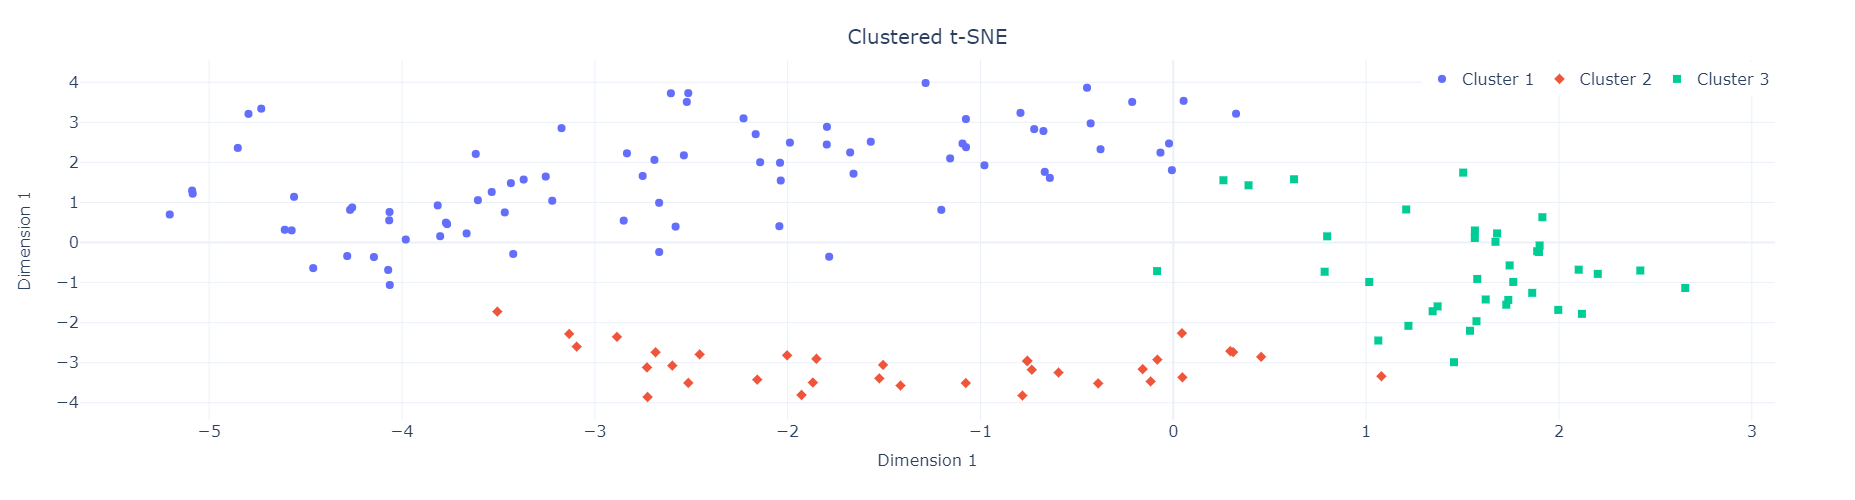

In [23]:
fig = px.scatter(plot_df, x="dim_1", y="dim_2", color="clusters", symbol="clusters", hover_name="LCLid")
fig.update_traces(marker=dict(size=8), selector=dict(mode='markers'))
format_plot(fig, xlabel="Dimension 1", ylabel="Dimension 1", title=f"Clustered t-SNE", font_size=16, legends=["Cluster 1", "Cluster 2", "Cluster 3"])
fig.write_image("imgs/chapter_8/clusters_tsne.png")
fig.show()

#### Using the clusters to partition

In [60]:
from lightgbm import LGBMRegressor
model_config = ModelConfig(
    model=LGBMRegressor(**best_params, verbose=-1),
    name="Tuned GFM+Meta+Clustered Part",
    # LGBM is not sensitive to normalized data
    normalize=False,
    # LGBM can handle missing values
    fill_missing=False,
)

In [61]:
y_pred_l = []
feat_df_l = []
time_elapsed_l = []
for acn in tqdm(cluster_df.unique(), desc="Training groups..."):
    lclids = cluster_df[cluster_df==acn].index
    _train_df = train_df.loc[train_df.LCLid.isin(lclids)]
    _test_df = test_df.loc[test_df.LCLid.isin(lclids)]
    train_features, train_target, train_original_target = _feat_config.get_X_y(
        _train_df, categorical=True, exogenous=False
    )
    # Loading the Validation as test
    test_features, test_target, test_original_target = _feat_config.get_X_y(
        _test_df, categorical=True, exogenous=False
    )
    cat_features = set(train_features.columns).intersection(
        _feat_config.categorical_features
    )
    _model_config = model_config.clone()
    with LogTime() as timer:
        y_pred, feat_df = train_model(
            _model_config,
            _feat_config,
            missing_value_config,
            train_features,
            train_target,
            test_features,
            fit_kwargs=dict(categorical_feature=cat_features),
        )
    y_pred_l.append(y_pred)
    feat_df_l.append(feat_df)
    time_elapsed_l.append(timer.elapsed)

Training groups...:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] lambda_l1 is set=8.160098582954642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.160098582954642
[LightGBM] [Warning] lambda_l2 is set=0.17840888757497253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17840888757497253
Time Elapsed: 38 seconds
[LightGBM] [Warning] lambda_l1 is set=8.160098582954642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.160098582954642
[LightGBM] [Warning] lambda_l2 is set=0.17840888757497253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17840888757497253
Time Elapsed: 15 seconds
[LightGBM] [Warning] lambda_l1 is set=8.160098582954642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.160098582954642
[LightGBM] [Warning] lambda_l2 is set=0.17840888757497253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17840888757497253
Time Elapsed: 11 seconds


In [62]:
y_pred = pd.concat(y_pred_l)

test_features, test_target, test_original_target = _feat_config.get_X_y(
    test_df, categorical=True, exogenous=False
)
train_features, train_target, train_original_target = _feat_config.get_X_y(
    train_df, categorical=True, exogenous=False
)

agg_metrics, eval_metrics_df = evaluate_forecast(y_pred, test_target, train_target, model_config)
agg_metrics["Time Elapsed"] = np.sum(time_elapsed_l)
metric_record.append(agg_metrics)
individual_metrics[model_config.name]=eval_metrics_df
pred_df = pred_df.join(y_pred)

Calculating metrics...:   0%|          | 0/150 [00:00<?, ?it/s]

In [63]:
pd.DataFrame(metric_record)

Algorithm       MAE       MSE  meanMASE  Forecast Bias  \
0                       LightGBM  0.077183  0.027510  0.978056       0.050231   
1                   GFM Baseline  0.079581  0.027326  1.013393       0.218127   
2        GFM+Meta (CountEncoder)  0.079411  0.027233  1.011801       0.037475   
3      GFM+Meta  (TargetEncoder)  0.079537  0.027218  1.012400       0.335610   
4         GFM+Meta  (NativeLGBM)  0.079209  0.027329  1.002630      -0.083755   
5                 Tuned GFM+Meta  0.072918  0.030641  0.900749     -12.412786   
6     Tuned GFM+Meta+Random Part  0.072598  0.030681  0.898618     -12.361642   
7      Tuned GFM+Meta+ACORN Part  0.072567  0.030786  0.898071     -12.316822   
8  Tuned GFM+Meta+Clustered Part  0.072347  0.029976  0.905182     -12.521149   

   Time Elapsed  
0           NaN  
1     28.718087  
2     68.020298  
3     43.607325  
4     30.316029  
5     57.936451  
6     49.178089  
7     52.118687  
8     66.373510

In [64]:
#Averaging feature importance across partitions (Dirty Approximation)
feat_df = feat_df_l.pop(0)
for i, d in enumerate(feat_df_l):
    feat_df = feat_df.merge(d, on="feature",suffixes=("","_{i}"))

feat_df["importance"] = feat_df.sum(axis=1)
feat_df = feat_df.loc[:, ["feature", "importance"]].sort_values("importance", ascending=False)

C:\Users\MANUJO~1\AppData\Local\Temp/ipykernel_28916/2437188547.py:6: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



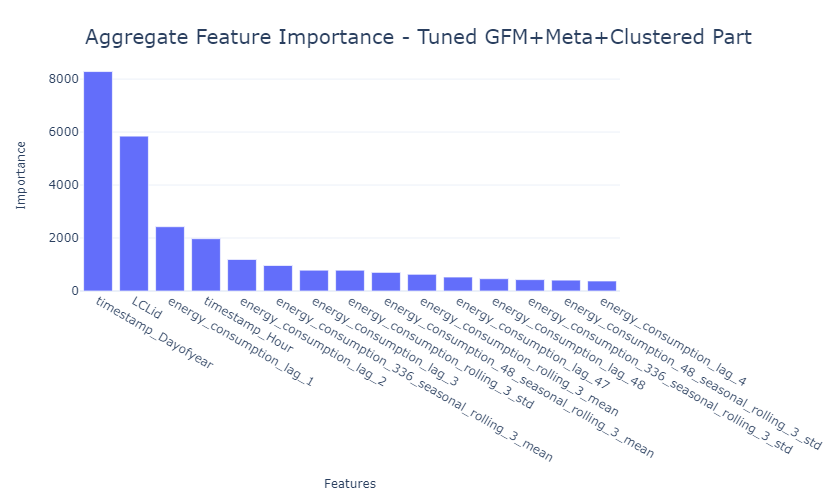

In [65]:
fig = px.bar(feat_df.head(15), x="feature", y="importance")
format_plot(fig, xlabel="Features", ylabel="Importance", title=f"Aggregate Feature Importance - {model_config.name}", font_size=12)
fig.write_image("imgs/chapter_8/clustered_partition_fimp.png")
fig.show()

## Summary

In [66]:
def highlight_abs_min(s, props=''):
    return np.where(s == np.nanmin(np.abs(s.values)), props, '')

In [67]:
agg_metrics = pd.DataFrame(metric_record)
agg_metrics.style.format(
    {"MAE": "{:.4f}", "MSE": "{:.4f}", "meanMASE": "{:.4f}", "Forecast Bias": "{:.2f}%"}
).highlight_min(color="lightgreen", subset=["MAE", "MSE", "meanMASE"]).apply(
    highlight_abs_min,
    props="color:black;background-color:lightgreen",
    axis=0,
    subset=["Forecast Bias"],
)

In [68]:
pred_df.head()

energy_consumption  GFM Baseline  \
LCLid     timestamp                                               
MAC000061 2014-01-01 00:00:00               0.165      0.132701   
          2014-01-01 00:30:00               0.167      0.120662   
          2014-01-01 01:00:00               0.150      0.126707   
          2014-01-01 01:30:00               0.091      0.115916   
          2014-01-01 02:00:00               0.047      0.078666   

                               GFM+Meta (CountEncoder)  \
LCLid     timestamp                                      
MAC000061 2014-01-01 00:00:00                 0.128619   
          2014-01-01 00:30:00                 0.121756   
          2014-01-01 01:00:00                 0.129756   
          2014-01-01 01:30:00                 0.115266   
          2014-01-01 02:00:00                 0.078193   

                               GFM+Meta  (TargetEncoder)  \
LCLid     timestamp                                        
MAC000061 2014-01-01 00:00:00                   0.130932   
          2014-01-01 00:30:00                   0.118489   
          2014-01-01 01:00:00                   0.129367   
          2014-01-01 01:30:00                   0.119371   
          2014-01-01 02:00:00                   0.078657   

                               GFM+Meta  (NativeLGBM)  Tuned GFM+Meta  \
LCLid     timestamp                                                     
MAC000061 2014-01-01 00:00:00                0.130299        0.121975   
          2014-01-01 00:30:00                0.121597        0.110917   
          2014-01-01 01:00:00                0.126879        0.124620   
          2014-01-01 01:30:00                0.113506        0.113383   
          2014-01-01 02:00:00                0.073068        0.063970   

                               Tuned GFM+Meta+Random Part  \
LCLid     timestamp                                         
MAC000061 2014-01-01 00:00:00                    0.135099   
          2014-01-01 00:30:00                    0.121260   
          2014-01-01 01:00:00                    0.147424   
          2014-01-01 01:30:00                    0.136911   
          2014-01-01 02:00:00                    0.068087   

                               Tuned GFM+Meta+ACORN Part  \
LCLid     timestamp                                        
MAC000061 2014-01-01 00:00:00                   0.133988   
          2014-01-01 00:30:00                   0.124745   
          2014-01-01 01:00:00                   0.146001   
          2014-01-01 01:30:00                   0.136179   
          2014-01-01 02:00:00                   0.060069   

                               Tuned GFM+Meta+Clustered Part  
LCLid     timestamp                                           
MAC000061 2014-01-01 00:00:00                       0.149277  
          2014-01-01 00:30:00                       0.097050  
          2014-01-01 01:00:00                       0.114042  
          2014-01-01 01:30:00                       0.093230  
          2014-01-01 02:00:00                       0.064595

In [69]:
individual_metrics.keys()

dict_keys(['GFM Baseline', 'GFM+Meta (CountEncoder)', 'GFM+Meta  (TargetEncoder)', 'GFM+Meta  (NativeLGBM)', 'Tuned GFM+Meta', 'Tuned GFM+Meta+Random Part', 'Tuned GFM+Meta+ACORN Part', 'Tuned GFM+Meta+Clustered Part'])

# Saving the GFM Forecasts and Metrics

In [70]:
os.makedirs("data/london_smart_meters/output", exist_ok=True)
output = Path("data/london_smart_meters/output")

In [71]:
pred_df.to_pickle(output/"gfm_predictions_val_df.pkl")
joblib.dump(individual_metrics, output/"gfm_metrics_val_df.pkl")
agg_metrics.to_pickle(output/"gfm_aggregate_metrics_val.pkl")